### 📚 Importación de librerías 

In [429]:
!pip install xlrd
!pip install psycopg2
!pip install install mysql-connector-python
!pip install pydotplus
!pip install graphviz
!pip install mglearn
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap
from Tools.scripts.dutree import display
from sklearn.tree import export_graphviz
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from IPython.display import display
import matplotlib.pyplot as plt
import mysql.connector as sql
from sklearn.svm import SVC 
from sklearn import metrics
from sklearn import tree
import psycopg2 as ps
import seaborn as sns
import pandas as pd
import numpy  as np
import pydotplus
import graphviz
import mglearn
import pickle
import xlrd

# Análisis del Dataset

In [430]:
# Se realiza la conexión a la base de datos
db_connection = sql.connect(host='localhost', database='proyecto_final_machine_learning', user='root', password='')
db_cursor = db_connection.cursor(buffered=True)

In [431]:
# Se realiza una query a la base de datos
db_cursor.execute("SELECT nombre_comun, pb, pap, dap, dap2, papdel, papgrueso, altura_fuste, altura_arbol, diferencia," 
                  "diametro_copa, tallos " 
                  "FROM censo " 
                  "where upper(edad) like 'MADURO' and "
                  "(nombre_comun like 'Palma areca'"
                  "or nombre_comun like 'Palma real de Cuba'" 
                  "or nombre_comun like 'Limon swinglea, Swinglea')")

# Los resultados se almacenan en table_rows
table_rows = db_cursor.fetchall()

# Se organiza un dataframe de pandas para el almacenamiento de los datos resultado de la query
df = pd.DataFrame(table_rows)

print(df.head())

                         0     1    2     3     4     5     6    7     8   \
0  Limon swinglea, Swinglea  1.45  0.0  0.18  0.18  0.45  0.71  5.0   9.0   
1               Palma areca  1.00  0.0  0.06  0.06  0.18  0.20  3.5   6.6   
2  Limon swinglea, Swinglea  1.42  0.0  0.19  0.19  0.54  0.68  5.5  10.5   
3        Palma real de Cuba  2.67  1.3  0.41  0.41  0.00  0.00  7.0  10.0   
4        Palma real de Cuba  2.90  2.1  0.67  0.67  0.00  0.00  7.0  10.0   

    9      10  11  
0  4.0   8.00   3  
1  3.1   5.00   4  
2  5.0   7.00   2  
3  3.0   5.12   1  
4  3.0  10.00   1  


In [432]:
# Se renombran las columnas del dataset ya que los nombres son columnas
df.columns = ['nombre_comun', 'pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste', 'altura_arbol', 'diferencia', 
              'diametro_copa', 'tallos']

print(df.head())

               nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  \
0  Limon swinglea, Swinglea  1.45  0.0  0.18  0.18    0.45       0.71   
1               Palma areca  1.00  0.0  0.06  0.06    0.18       0.20   
2  Limon swinglea, Swinglea  1.42  0.0  0.19  0.19    0.54       0.68   
3        Palma real de Cuba  2.67  1.3  0.41  0.41    0.00       0.00   
4        Palma real de Cuba  2.90  2.1  0.67  0.67    0.00       0.00   

   altura_fuste  altura_arbol  diferencia  diametro_copa  tallos  
0           5.0           9.0         4.0           8.00       3  
1           3.5           6.6         3.1           5.00       4  
2           5.5          10.5         5.0           7.00       2  
3           7.0          10.0         3.0           5.12       1  
4           7.0          10.0         3.0          10.00       1  


In [433]:
# Se analiza la frecuencia de cada especie en el dataset
print(df['nombre_comun'].value_counts() )

Limon swinglea, Swinglea    1196
Palma areca                  530
Palma real de Cuba           503
Name: nombre_comun, dtype: int64


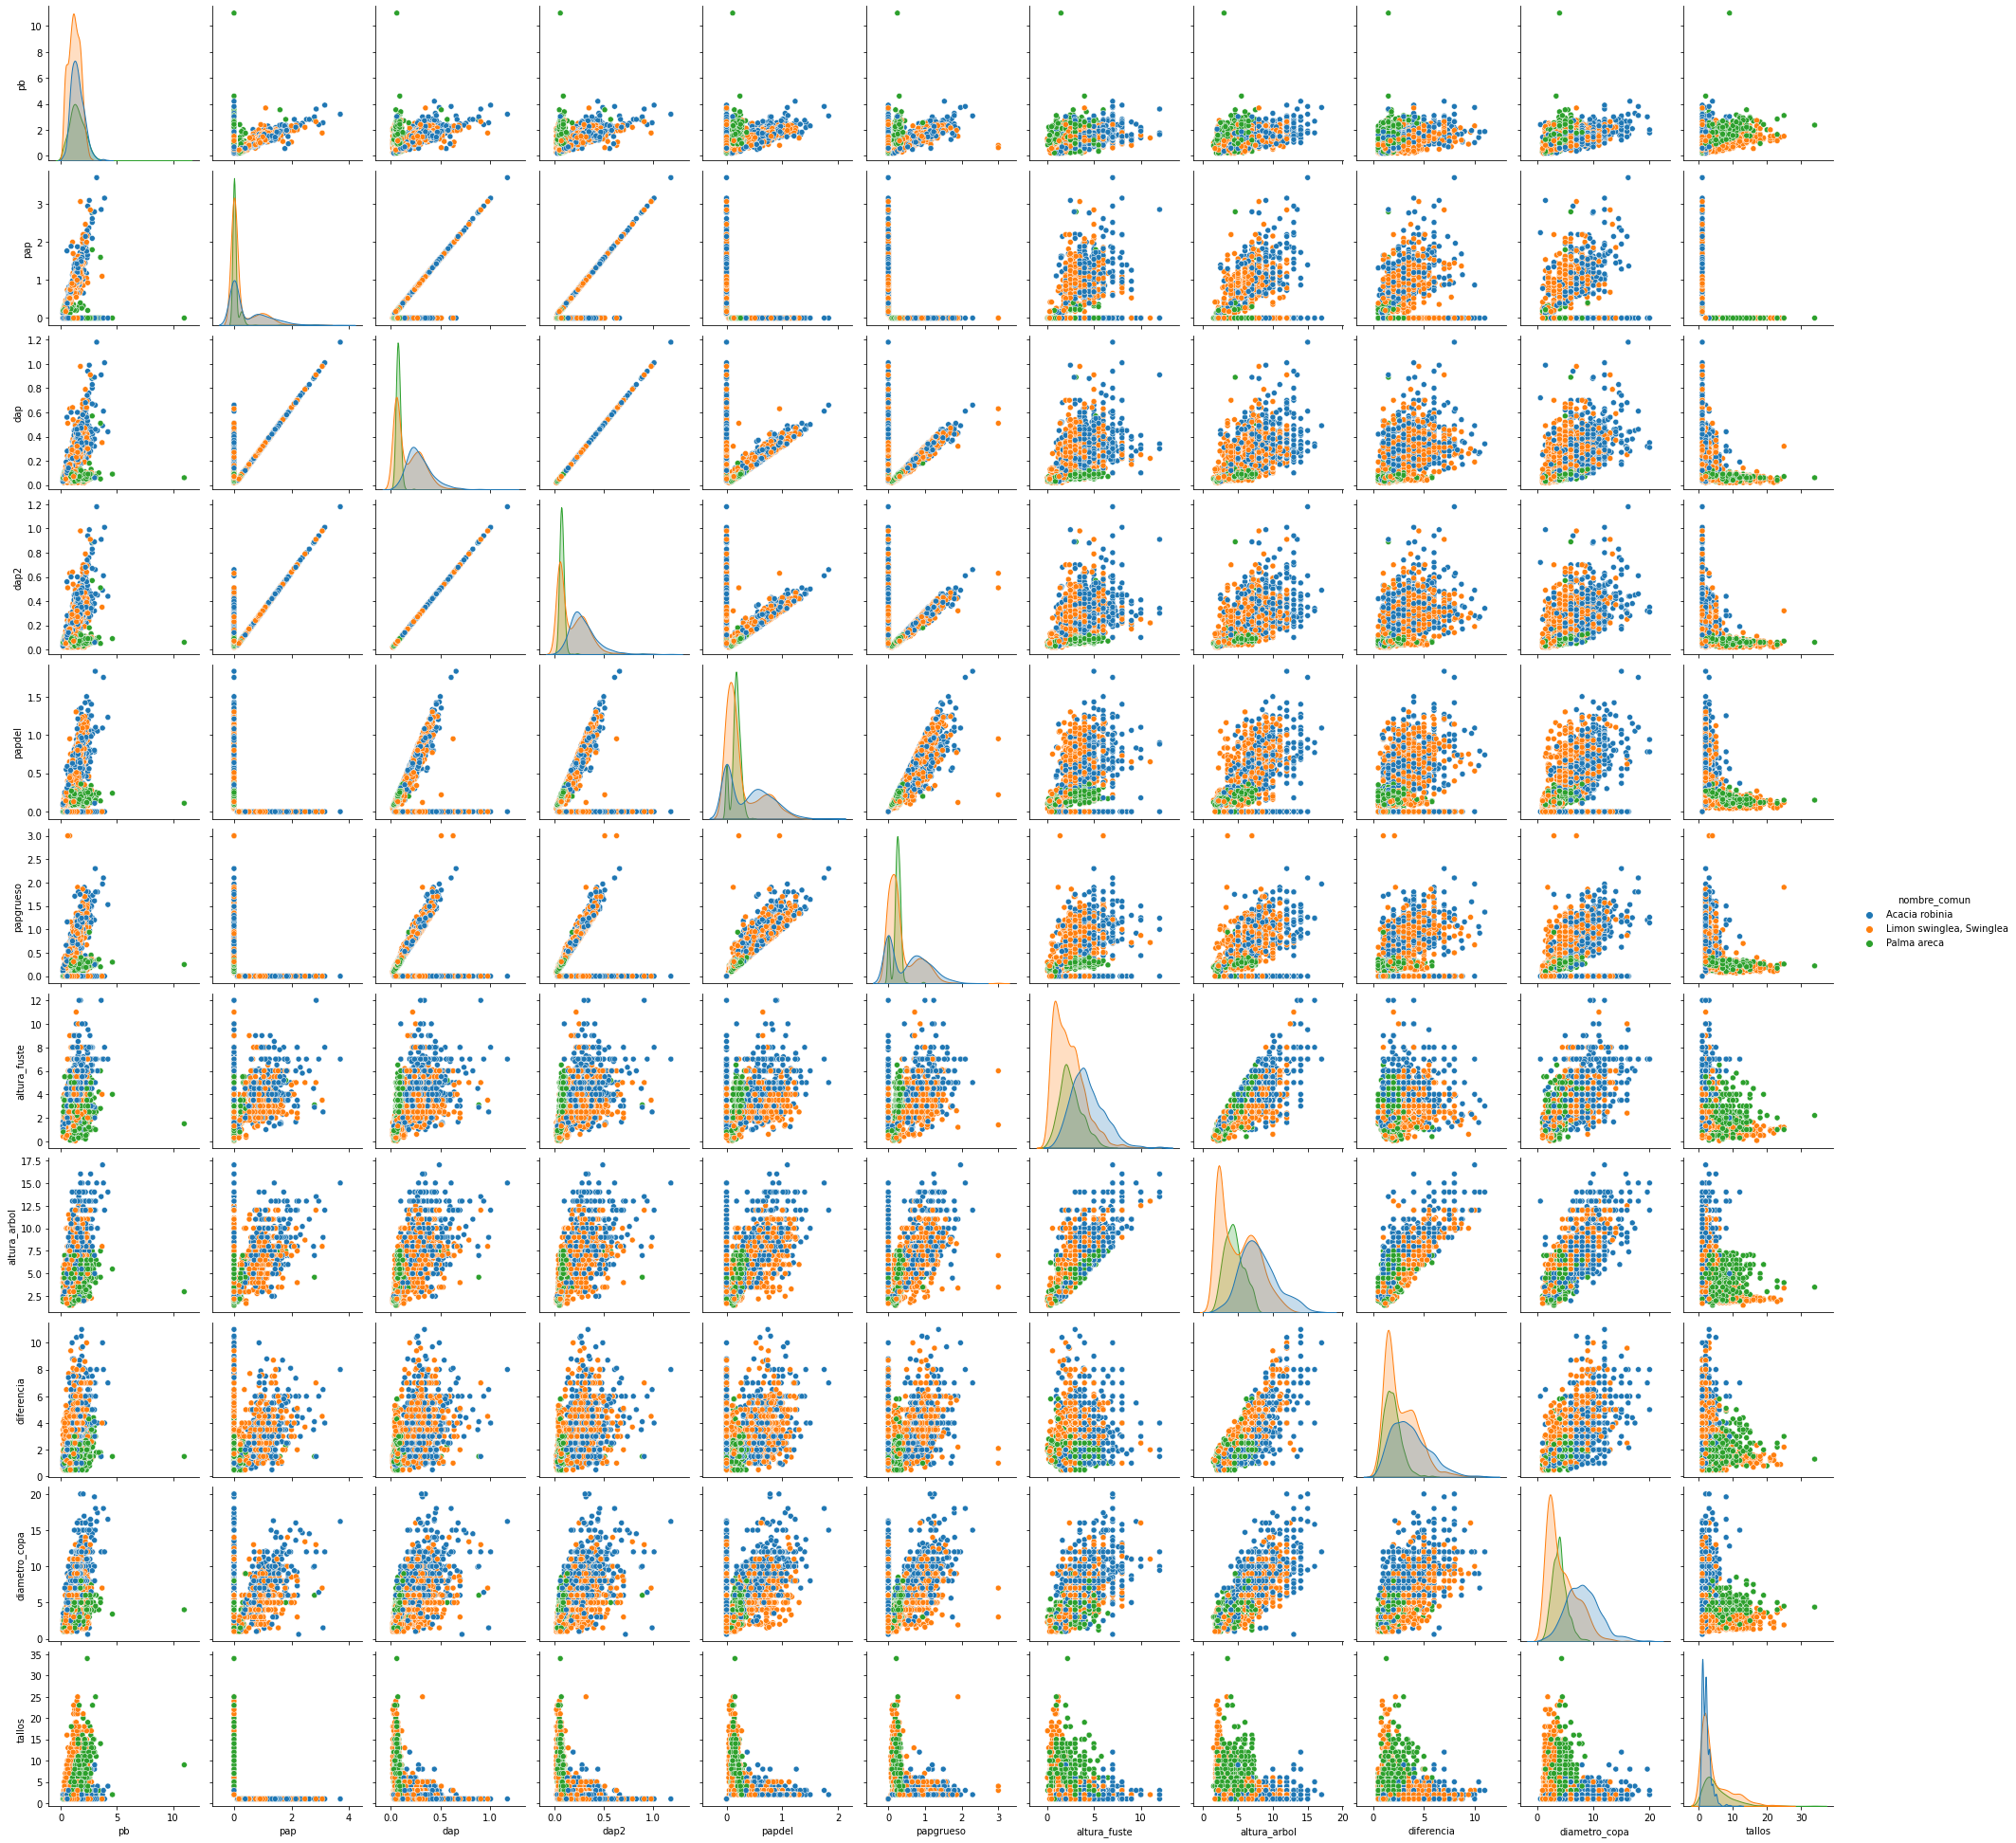

In [378]:
sns_plot = sns.pairplot(df, hue='nombre_comun')
plt.show()
sns_plot.savefig("resources\sns_pairplot.png")

In [434]:
# Se hace una tranformación de los target (Nombre de las especies) a valores númericos para que puedan ser procesados
df['nombre_comun'].replace(to_replace=['Palma real de Cuba', 'Limon swinglea, Swinglea', 'Palma areca'], value=[0, 1, 2], inplace=True)

# Se separan los features del dataset
x = df[['pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste','altura_arbol', 'diferencia', 'diametro_copa', 
        'tallos']]  

# Se extraen los target del dataset
y = df['nombre_comun']

print(np.unique(y))

# Se separa el train y test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts())

[0 1 2]
(1560, 11)
(669, 11)
(1560,)
(669,)
1    837
2    371
0    352
Name: nombre_comun, dtype: int64


# Modelo 1 Random Forest Classifier RFC (Sólo variables continuas)

Se realiza el entrenamiento del modelo teniendo en cuenta sólo las variables continuas y se analiza su predicción.

Mejor accuracy:  0.9013452914798207  con N_Estimators:  200


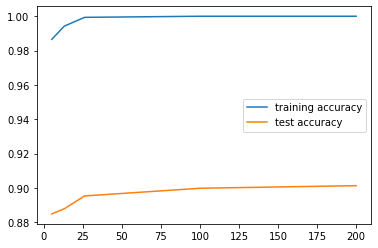

In [435]:
# El objetivo es obtener la evaluación de complejidad
training_accuracy_clf1 = []
test_accuracy_clf1 = []
best_test_accuracy_clf1 = 0
best_model_clf1 = None
n_estimators_best_test_accuracy_clf1 = 0
test_score_clf1 = 0

# Se realiza el entrenamiento distintos estimadores
estimators_settings = [5, 13, 26, 100, 200]
for n_estimators in estimators_settings:
    
    # Se crea una instacia del random forest classifier
    clf1 = RandomForestClassifier(max_features=1, n_estimators=n_estimators, random_state=2)

    # Se entrena el modelo con el train dataset
    clf1.fit(x_train.values, y_train)

    # Se realiza la predicción con el train y test dataset
    y_train_pred = clf1.predict(x_train.values)
    y_test_pred = clf1.predict(x_test)
    
    # Se guarda el accuracy con el train dataset
    training_accuracy_clf1.append(metrics.accuracy_score(y_train, y_train_pred))
    # Se guarda el accuracy con el test dataset
    test_score_clf1 = metrics.accuracy_score(y_test, y_test_pred)
    test_accuracy_clf1.append(test_score_clf1)
    
    # Si el accuracy es el más alto, se guarda junto con el vecino
    if test_score_clf1 > best_test_accuracy_clf1:
        best_test_accuracy_clf1 = test_score_clf1
        n_estimators_best_test_accuracy_clf1 = n_estimators
        best_model_clf1 = clf1

# Se imprime el mejor score
print("Mejor accuracy: ", best_test_accuracy_clf1, " con N_Estimators: ", n_estimators_best_test_accuracy_clf1)
# Se imprimen los resultados en un subplot
plt.plot(estimators_settings, training_accuracy_clf1, label="training accuracy")
plt.plot(estimators_settings, test_accuracy_clf1, label="test accuracy")
plt.legend()
plt.show()

In [436]:
# Se hace la predicción con una Palma Areca del dataset original
print(best_model_clf1.predict([[1.34, 0, 0.05, 0.05, 0.12, 0.2, 0.5, 1.7, 1.2, 2.8, 10]]))

[1]


In [437]:
# Se hace la predicción con la Palma Areca con Id_Arbol=54919 de Prados del Norte pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(best_model_clf1.predict([[0.32, 0.24, 0.08, 0.08, 0, 0, 4, 7, 3, 1.5, 1]]))

[1]


In [438]:
# Se hace la predicción con la Palma Areca con Id_Arbol=70481 de Normandia pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(best_model_clf1.predict([[2.56, 0, 0.08, 0.08, 0.21, 0.28, 5.5, 7.3, 1.8, 4.8, 6]]))

[2]


# Pre-processing 1 One-Hot Encoding (Variable "Vegetación") - Modelo 1 RFC

Se realiza codificación One-Hot para utilizar esta variable en el entrenamiento del modelo.

In [439]:
db_cursor.execute("SELECT nombre_comun, pb, pap, dap, dap2, papdel, papgrueso, altura_fuste, altura_arbol, diferencia," 
                  "diametro_copa, tallos, vegetacion " 
                  "FROM censo " 
                  "where upper(edad) like 'MADURO' and "
                  "(nombre_comun like 'Palma areca'"
                  "or nombre_comun like 'Palma real de Cuba'" 
                  "or nombre_comun like 'Limon swinglea, Swinglea')")

# Los resultados se almacenan en table_rows
table_rows = db_cursor.fetchall()

# Se organiza un dataframe de pandas para el almacenamiento de los datos resultado de la query
df = pd.DataFrame(table_rows)

# Se renombran las columnas del dataset ya que los nombres son columnas
df.columns = ['nombre_comun', 'pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste', 'altura_arbol', 'diferencia', 
              'diametro_copa', 'tallos', 'vegetacion']

# Se hace una tranformación de los target (Nombre de las especies) a valores númericos para que puedan ser procesados
df['nombre_comun'].replace(to_replace=['Palma real de Cuba', 'Limon swinglea, Swinglea', 'Palma areca'], value=[0, 1, 2], inplace=True)

In [440]:
print(df['vegetacion'].values)

['Arbol' 'Palma' 'Arbol' ... 'Palma' 'Palma' 'Arbol']


In [441]:
y = pd.get_dummies(df['vegetacion'], prefix='veg')

In [442]:
veg_Arbol = y['veg_Arbol']
print(print(veg_Arbol))

0       1
1       0
2       1
3       0
4       0
       ..
2224    0
2225    0
2226    0
2227    0
2228    1
Name: veg_Arbol, Length: 2229, dtype: uint8
None


In [443]:
veg_Palma = y['veg_Palma']
print(veg_Palma)

0       0
1       1
2       0
3       1
4       1
       ..
2224    1
2225    1
2226    1
2227    1
2228    0
Name: veg_Palma, Length: 2229, dtype: uint8


In [444]:
df = df.drop('vegetacion', 1)

In [445]:
df.insert(len(df.columns), "veg_Palma", veg_Palma, True)
print(df.head())

   nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  altura_fuste  \
0             1  1.45  0.0  0.18  0.18    0.45       0.71           5.0   
1             2  1.00  0.0  0.06  0.06    0.18       0.20           3.5   
2             1  1.42  0.0  0.19  0.19    0.54       0.68           5.5   
3             0  2.67  1.3  0.41  0.41    0.00       0.00           7.0   
4             0  2.90  2.1  0.67  0.67    0.00       0.00           7.0   

   altura_arbol  diferencia  diametro_copa  tallos  veg_Palma  
0           9.0         4.0           8.00       3          0  
1           6.6         3.1           5.00       4          1  
2          10.5         5.0           7.00       2          0  
3          10.0         3.0           5.12       1          1  
4          10.0         3.0          10.00       1          1  


In [446]:
df.insert(len(df.columns), "veg_Arbol", veg_Arbol, True)
print(df.head())

   nombre_comun    pb  pap   dap  dap2  papdel  papgrueso  altura_fuste  \
0             1  1.45  0.0  0.18  0.18    0.45       0.71           5.0   
1             2  1.00  0.0  0.06  0.06    0.18       0.20           3.5   
2             1  1.42  0.0  0.19  0.19    0.54       0.68           5.5   
3             0  2.67  1.3  0.41  0.41    0.00       0.00           7.0   
4             0  2.90  2.1  0.67  0.67    0.00       0.00           7.0   

   altura_arbol  diferencia  diametro_copa  tallos  veg_Palma  veg_Arbol  
0           9.0         4.0           8.00       3          0          1  
1           6.6         3.1           5.00       4          1          0  
2          10.5         5.0           7.00       2          0          1  
3          10.0         3.0           5.12       1          1          0  
4          10.0         3.0          10.00       1          1          0  


In [447]:
# Se separan los features del dataset
x = df[['pb', 'pap', 'dap', 'dap2', 'papdel', 'papgrueso', 'altura_fuste','altura_arbol', 'diferencia', 'diametro_copa', 
        'tallos', 'veg_Palma', 'veg_Arbol']]

# Se extraen los target del dataset
y = df['nombre_comun']

print("Targets: ", np.unique(y))

# Se separa el train y test dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

print("Ejemplo de un row de train dataset: ", x_train.values[0])

Targets:  [0 1 2]
Ejemplo de un row de train dataset:  [0.6  0.   0.09 0.09 0.15 0.4  1.6  4.   2.4  2.5  2.   0.   1.  ]


Mejor accuracy:  0.9955156950672646  con N_Estimators:  13


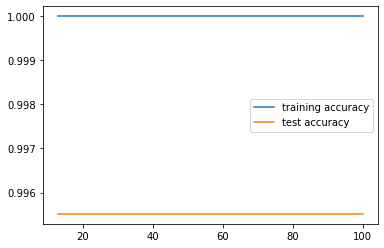

In [449]:
# El objetivo es obtener la evaluación de complejidad
training_accuracy_clf2 = []
test_accuracy_clf2 = []
best_test_accuracy_clf2 = 0
best_model_clf2 = None
n_estimators_best_test_accuracy_clf2 = 0
test_score_clf2 = 0

# Se realiza el entrenamiento con k de 1 a 14
estimators_settings = [13, 26, 100]
for n_estimators in estimators_settings:
    
    # Se crea una instacia del random forest classifier
    clf2 = RandomForestClassifier(max_features=1, n_estimators=n_estimators, random_state=2)

    # Se entrena el modelo con el train dataset
    clf2.fit(x_train.values, y_train)

    # Se realiza la predicción con el train y test dataset
    y_train_pred_clf2 = clf2.predict(x_train)
    y_test_pred_clf2 = clf2.predict(x_test)
    
    # Se guarda el accuracy con el train dataset
    training_accuracy_clf2.append(metrics.accuracy_score(y_train, y_train_pred_clf2))
    # Se guarda el accuracy con el test dataset
    test_score_clf2 = metrics.accuracy_score(y_test, y_test_pred_clf2)
    test_accuracy_clf2.append(test_score_clf2)
    
    # Si el accuracy es el más alto, se guarda junto con el vecino
    if test_score_clf2 > best_test_accuracy_clf2:
        best_test_accuracy_clf2 = test_score_clf2
        n_estimators_best_test_accuracy_clf2 = n_estimators
        best_model_clf2 = clf2

# Se imprime el mejor score
print("Mejor accuracy: ", best_test_accuracy_clf2, " con N_Estimators: ", n_estimators_best_test_accuracy_clf2)
# Se imprimen los resultados en un subplot
plt.plot(estimators_settings, training_accuracy_clf2, label="training accuracy")
plt.plot(estimators_settings, test_accuracy_clf2, label="test accuracy")
plt.legend()
plt.show()

In [450]:
# Se hace la predicción con la Palma Areca con Id_Arbol=54919 de Prados del Norte pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(best_model_clf2.predict([[0.32, 0.24, 0.08, 0.08, 0, 0, 4, 7, 3, 1.5, 1, 1, 0]]))

[2]


In [451]:
# Se hace la predicción con la Palma Areca con Id_Arbol=70481 de Normandia pertenenciente al dataset del censo 
# arboreo de la comuna 2
print(best_model_clf2.predict([[2.56, 0, 0.08, 0.08, 0.21, 0.28, 5.5, 7.3, 1.8, 4.8, 6, 1, 0]]))

[2]


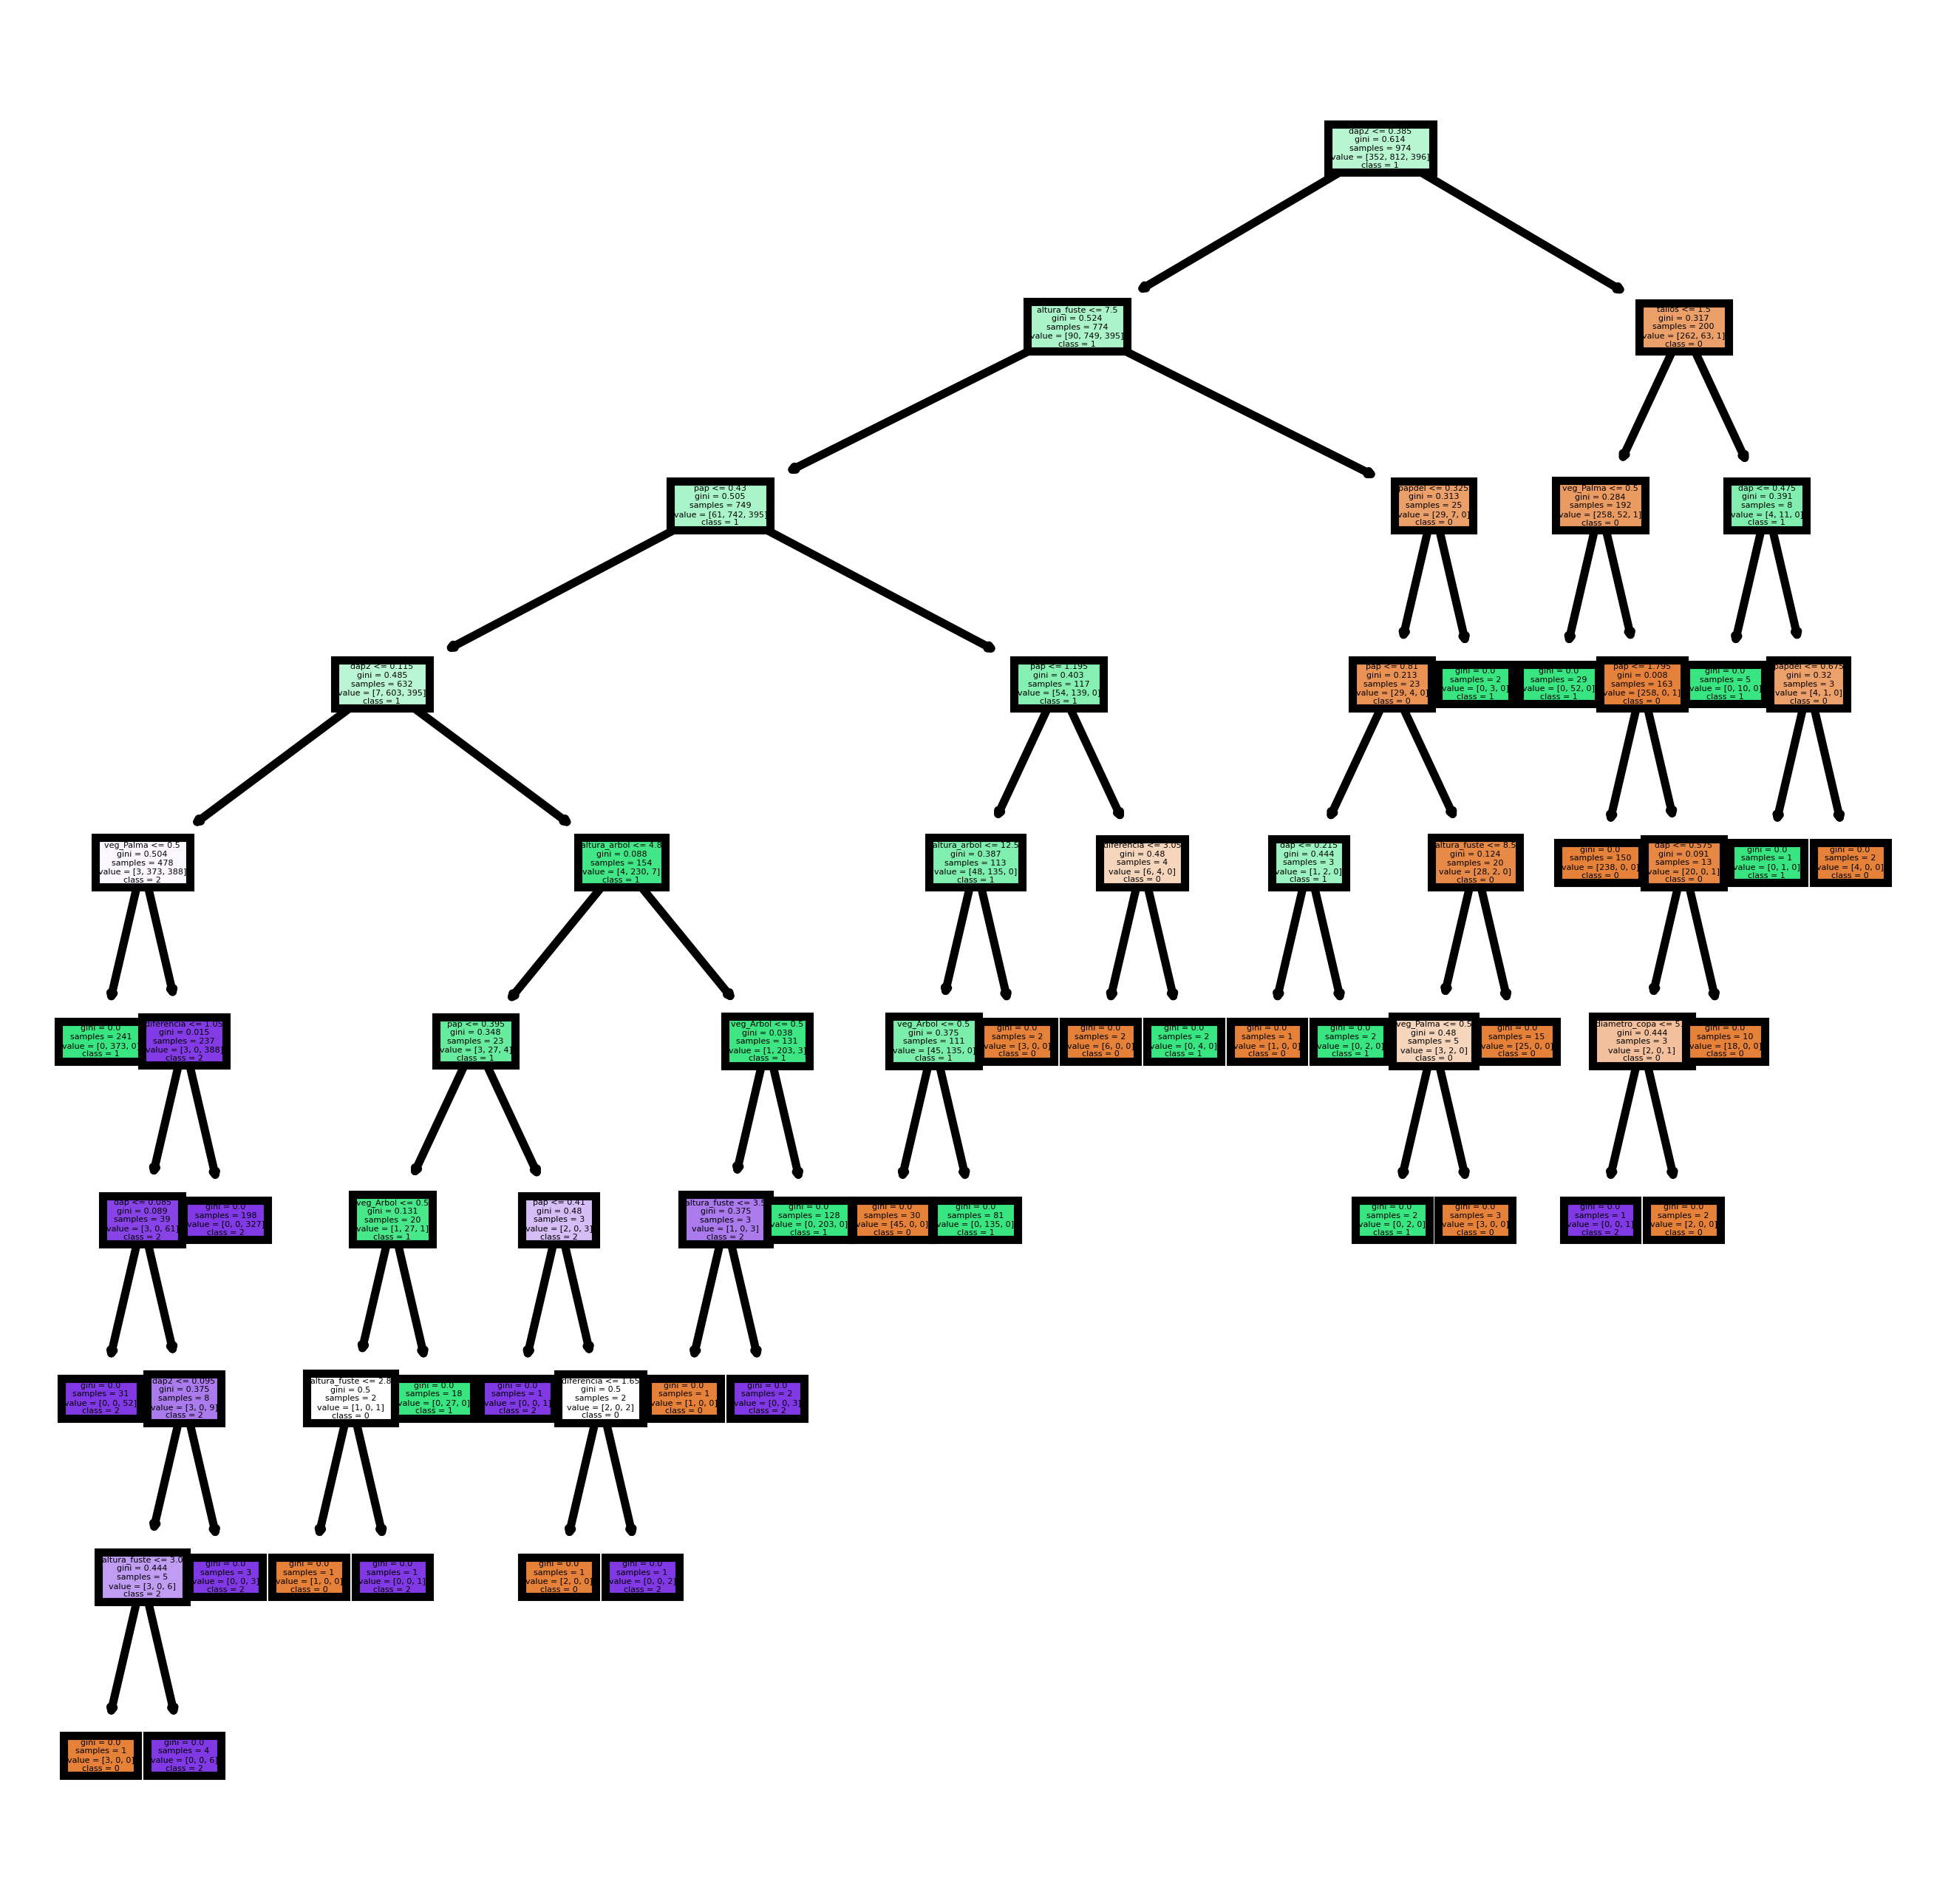

In [452]:
feature_names = df.columns
feature_names = feature_names.drop('nombre_comun')

# Exportar arbol número 0 como archivo dot
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(best_model_clf2.estimators_[0], feature_names = feature_names, class_names = ["0", "1", "2"], filled = True)
fig.savefig('resources/1_tree.png')

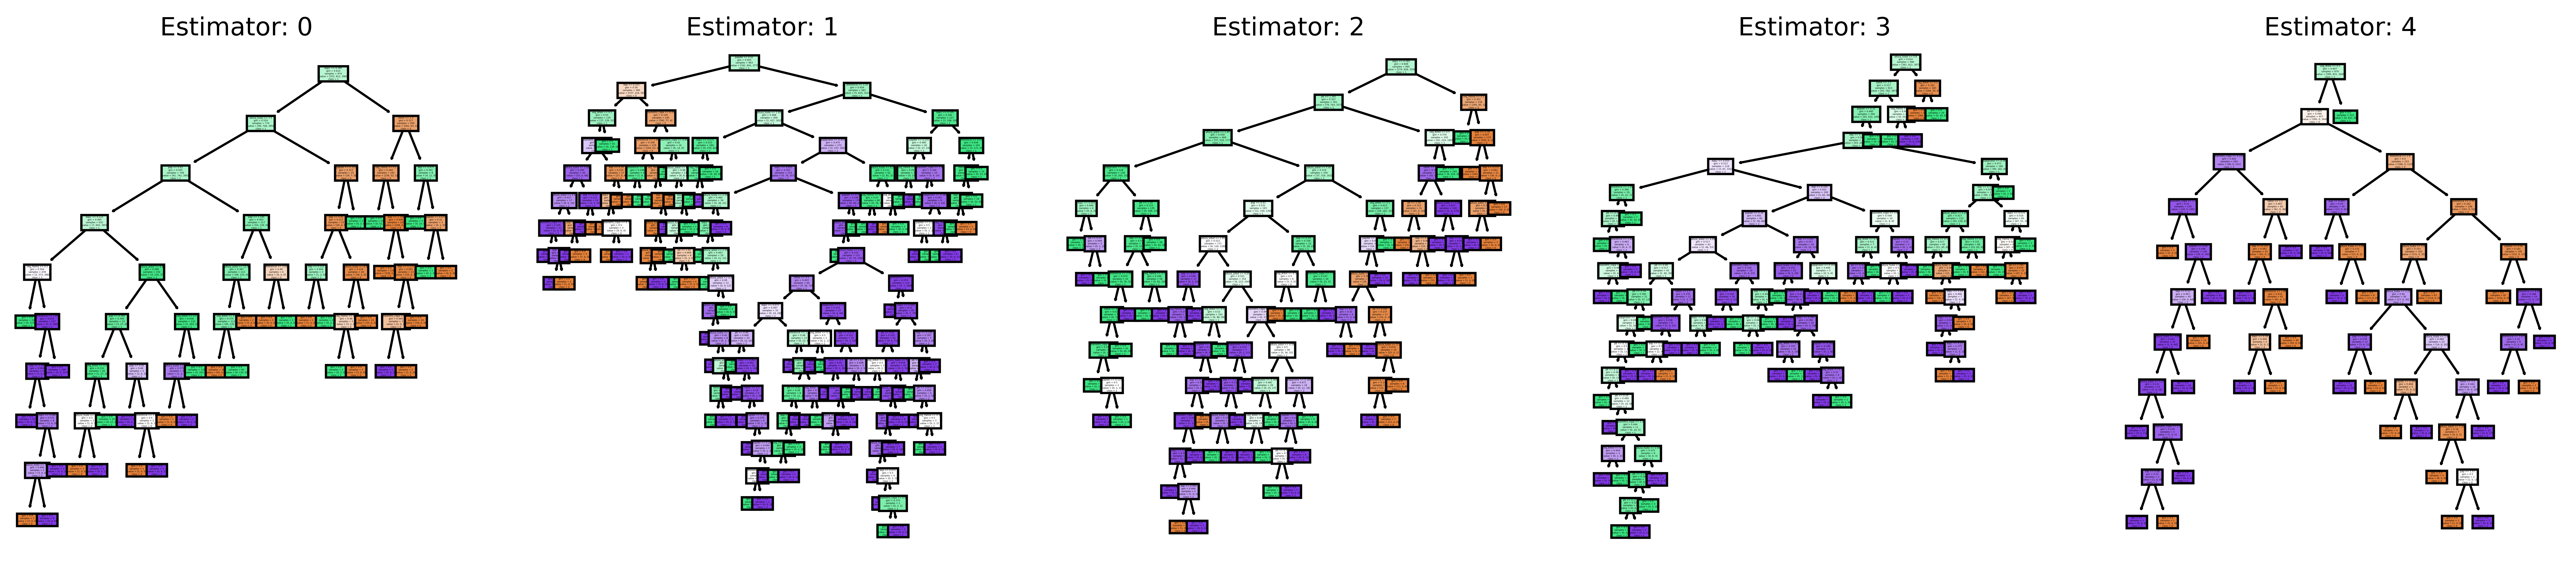

In [453]:
# Los primeros 5 arboles/estimadores 0, 1, 2, 3, 4 se verán algo pequeños pero se pueden comparar fácilmente de una forma visual
fig, axes = plt.subplots(nrows = 1,ncols = 5, figsize = (20,4), dpi=900)
for index in range(0, 5):
    tree.plot_tree(best_model_clf2.estimators_[index], feature_names = feature_names, class_names = ["0", "1", "2"], filled = True, ax = axes[index]);
    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('resources/5_trees.png')

Ranking de Features:
1. feature 12 (0.259104)
2. feature 11 (0.217908)
3. feature 3 (0.122212)
4. feature 6 (0.070632)
5. feature 2 (0.048249)
6. feature 7 (0.047814)
7. feature 1 (0.044164)
8. feature 0 (0.043940)
9. feature 4 (0.035622)
10. feature 5 (0.033357)
11. feature 10 (0.032751)
12. feature 9 (0.022696)
13. feature 8 (0.021551)


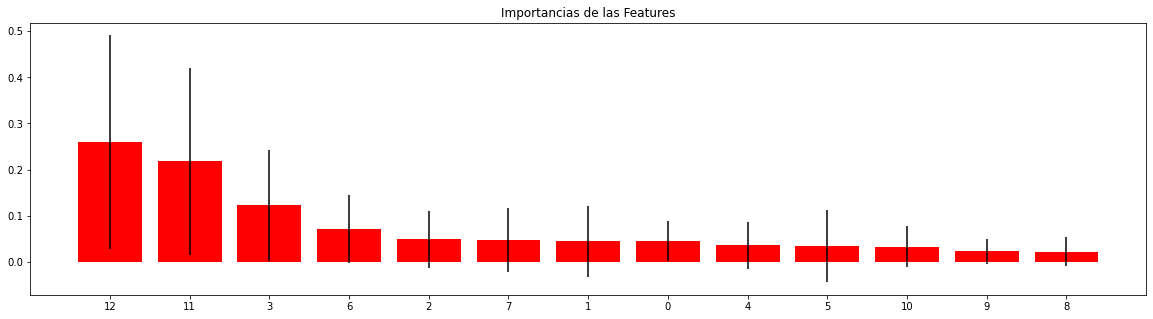

In [454]:
# Se obtienen las importancias del arbol, basado en el ejemplo de scikit learn 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = best_model_clf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model_clf2.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Se imprime el ranking de Features
print("Ranking de Features:")

for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot de la importancia de las features en el forest de acuerdo a la impureza
plt.figure(figsize=(20, 5))
plt.title("Importancias de las Features")
plt.bar(range(x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x.shape[1]), indices)
plt.xlim([-1, x.shape[1]])
plt.show()

# Pre-processing 2 y 3 Reducción de dimensionalidad con PCA y Standard Scaler

In [455]:
# Se crea una instancia del escalador para preprocesamiento
scaler = StandardScaler()

# Se entrena el modelo con el data del boston dataset
scaler.fit(x.values)

# Se escala el train dataset y el test dataset
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Se mantendrán las dos primeras componentes del dataset, por lo tanto
# se crea una instancia del PCA con n_components=2
pca_clf3 = PCA(n_components=2)

# Se entrena el modelo PCA con el train dataset de boston escalado
pca_clf3.fit(x_train_scaled)

# Se transforma el dataset en sus dos principales componentes
x_train_pca = pca_clf3.transform(x_train_scaled)
x_test_pca = pca_clf3.transform(x_test_scaled)

# Se imprimen los shapes de los distintos sets de datos
print("Original shape: {}".format(str(x.shape)))
print("Type Original shape: {}".format(type(x.shape)))
print("Original shape: {}".format(str(x_train_scaled.shape)))
print("Type Original shape: {}".format(type(x_train_scaled)))
print("Reduced shape: {}".format(str(x_train_pca.shape)))
print("Type Reduced shape: {}".format(type(x_train_pca)))

Original shape: (2229, 13)
Type Original shape: <class 'tuple'>
Original shape: (1560, 13)
Type Original shape: <class 'numpy.ndarray'>
Reduced shape: (1560, 2)
Type Reduced shape: <class 'numpy.ndarray'>


# Modelo 1 RFC

Mejor accuracy:  0.9641255605381166  con N_Estimators:  100


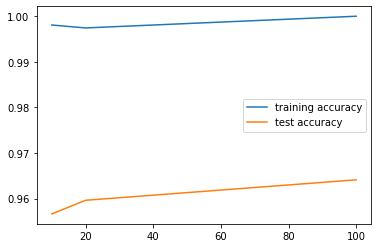

In [456]:
# El objetivo es obtener la evaluación de complejidad
training_accuracy_clf3 = []
test_accuracy_clf3 = []
best_test_accuracy_clf3 = 0
n_estimators_best_test_accuracy_clf3 = 0
test_score_clf3 = 0

# Se realiza el entrenamiento con k de 1 a 14
estimators_settings = [10, 20, 100]
for n_estimators in estimators_settings:
    
    # Se crea una instacia del random forest classifier
    clf3 = RandomForestClassifier(n_estimators=n_estimators)

    # Se entrena el modelo con el train dataset
    clf3.fit(x_train_pca, y_train)

    # Se realiza la predicción con el train y test dataset
    y_train_pred_clf3 = clf3.predict(x_train_pca)
    y_test_pred_clf3 = clf3.predict(x_test_pca)
    
    # Se guarda el accuracy con el train dataset
    training_accuracy_clf3.append(metrics.accuracy_score(y_train, y_train_pred_clf3))
    # Se guarda el accuracy con el test dataset
    test_score_clf3 = metrics.accuracy_score(y_test, y_test_pred_clf3)
    test_accuracy_clf3.append(test_score_clf3)
    
    # Si el accuracy es el más alto, se guarda junto con el vecino
    if test_score_clf3 > best_test_accuracy_clf3:
        best_test_accuracy_clf3 = test_score_clf3
        n_estimators_best_test_accuracy_clf3 = n_estimators

# Se imprime el mejor score
print("Mejor accuracy: ", best_test_accuracy_clf3, " con N_Estimators: ", n_estimators_best_test_accuracy_clf3)
# Se imprimen los resultados en un subplot
plt.plot(estimators_settings, training_accuracy_clf3, label="training accuracy")
plt.plot(estimators_settings, test_accuracy_clf3, label="test accuracy")
plt.legend()
plt.show()

# Modelo 2 KNC

Mejor accuracy:  0.9656203288490284  con N_Neighbors:  11


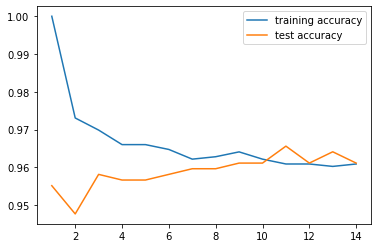

In [457]:
# El objetivo es obtener la evaluación de complejidad
training_accuracy = []
test_accuracy = []
best_test_accuracy = 0
n_neighbors_best_test_accuracy = 0

# Se realiza el entrenamiento con k de 1 a 14
neighbors_settings = range(1, 15)
for n_neighbors in neighbors_settings:
    # Se construye el modelo
    clf4 = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf4.fit(x_train_pca, y_train)
    # Se guarda el accuracy con el train dataset
    training_accuracy.append(clf4.score(x_train_pca, y_train))
    # Se guarda el accuracy con el test dataset
    test_score = clf4.score(x_test_pca, y_test)
    test_accuracy.append(test_score)
    # Si el accuracy es el más alto, se guarda junto con el vecino
    if test_score > best_test_accuracy:
        best_test_accuracy = test_score
        n_neighbors_best_test_accuracy = n_neighbors

# Se imprime el mejor score
print("Mejor accuracy: ", best_test_accuracy, " con N_Neighbors: ", n_neighbors_best_test_accuracy)
# Se imprimen los resultados en un subplot
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.legend()
plt.show()

# Modelo 3 One vs Rest

In [458]:
# Creating the SVM model 
model_svm = OneVsRestClassifier(SVC()) 
   
# Fitting the model with training data 
model_svm.fit(x_train_pca, y_train) 
   
# Making a prediction on the test set 
prediction = model_svm.predict(x_test_pca) 
   
# Evaluating the model 
print(f"Test Set Accuracy : {accuracy_score(y_test, prediction) * 100} %\n\n") 
print(f"Classification Report : \n\n{classification_report(y_test, prediction)}") 

Test Set Accuracy : 95.96412556053812 %


Classification Report : 

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       143
           1       0.99      0.96      0.97       368
           2       0.90      0.97      0.93       158

    accuracy                           0.96       669
   macro avg       0.95      0.96      0.95       669
weighted avg       0.96      0.96      0.96       669



# 📦 Empacando el modelo (Pickling)

In [ ]:
# Pickling convierte el objeto en un stream de bytes que pueden ser almacenados, transferidos y convertidos de nuevo al modelo
# original luego. Pickles es una de las formas que tiene python para guardar cualquier cosa fuera de la caja. Nuestro modelo es
# guardado como un pickle en el mismo directorio de nuestro notebook de jupyter.
pickl = {'model': clf_2}
pickle.dump( pickl, open( 'resources/models/model_rfc_file' + ".p", "wb" ) )